# Text Classification using RNN and NLP

In this Jupyter Notebook, we will use RNN in conjunction with NLP to classify disaster tweets as whether the tweet is a real disaster or not.

Natural Language Processing allows us to take texts from sources like Twitter and convert them to numbers so we can do things like classification.

Data was retrieved from the following Kaggle competition: 
Natural language processing with disaster tweets. Kaggle. (n.d.). Retrieved April 28, 2022, from https://www.kaggle.com/competitions/nlp-getting-started/overview 

In [1]:
import pandas as pd

In [2]:
cd Downloads

/Users/richard/Downloads


In [3]:
train = pd.read_csv('train (1).csv')
test = pd.read_csv('test (1).csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


train has 7613 tweets whereas test has 3263 tweets. train has one extra column because test does not have a target column

In [5]:
train.shape

(7613, 5)

In [6]:
test.shape

(3263, 4)

In [7]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Looks like there are more 0's in train than 1's

In [760]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:>

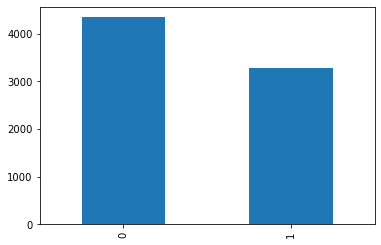

In [767]:
train['target'].value_counts().plot(kind='bar')

In [8]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')

You can see a nice visualization below that shows the type of certain words for a given tweet

In [9]:
doc = nlp(train['text'].iloc[49])
displacy.render(doc, style='ent', jupyter=True)

Here is another visualization

In [10]:
doc = nlp(train['text'].iloc[109])
displacy.render(doc, style='ent', jupyter=True)

The following function will preprocess our data. Most importantly it will remove stop words from the text as these words will not add anything of value to our model later on

In [11]:
import re
import nltk
from nltk.corpus import stopwords
def text_preprocess(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub("[^0-9a-zA-Z]", ' ', text)
    text = text.lower().split()
    stop_words = set(stopwords.words("english"))
    text = [w for w in text if w not in stop_words]
    text = " ".join(text)
    return text

You can see the function got rid of the links in the front and the back of the following tweet and made all of the words lower case as well

In [12]:
train['text'][172]

'http://t.co/AY6zzcUpnz Twelve feared killed in Pakistani air ambulance helicopter crash http://t.co/sC9dNS41Mc'

In [13]:
text_preprocess(train['text'][172])

'twelve feared killed pakistani air ambulance helicopter crash'

Time to tokenize all of the words in each tweet

In [14]:
from nltk import word_tokenize
tokenized_text = []
for text in range(0,len(train)):
    a = word_tokenize(text_preprocess(train['text'].iloc[text]))
    tokenized_text.append(a)

In [15]:
tokenized_text[9]

['afraid', 'tornado', 'coming', 'area']

Let's create a list of all of the words in tokenized_text and keep only one of each word

In [16]:
list_of_words = []
for text in tokenized_text: 
    for word in text:
        list_of_words.append(word.lower())

In [776]:
# sets only contain unique values

In [17]:
list_of_words = list(set(list_of_words))

Let's find out how long each tweet is after preprocessing

In [18]:
length_ = []
for length in range(len(tokenized_text)):
    length_.append(len(tokenized_text[length]))

Looks like the mean is about 9.5

In [19]:
from statistics import mean
print(mean(length_))
print(max(length_))
print(min(length_))

9.491527650072245
27
1


In [20]:
import seaborn as sns

Here is a histogram of the lengths of the texts in train after preprocessing

<AxesSubplot:ylabel='Count'>

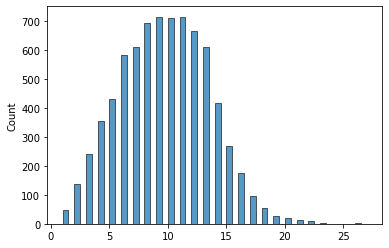

In [21]:
sns.histplot(length_)

There are 16,824 unique words in train's text column after preprocessing

In [22]:
len(list_of_words)

16824

Time to vectorize the tokenized_text list

In [23]:
from keras.preprocessing import text, sequence
vectorizer = text.Tokenizer()
vectorizer.fit_on_texts(tokenized_text)
vectorized_text = vectorizer.texts_to_sequences(tokenized_text)
X = sequence.pad_sequences(vectorized_text,maxlen=26)

In [24]:
y = train['target']

Let's split the data. We will use 0.01 as test_size because we don't have a lot of data. We would like the model to have as much to train on as possible

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

In [26]:
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, GlobalMaxPool1D, BatchNormalization, MaxPool1D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

Let's create our model. We will adjust the adam learning rate, then start by adding an embedding layer. This layer is important since the data we will be feeding the model will be a matrix. After, we will add a LSTM layer which is the RNN part of this model. Then we will add 3 dense layers with the last layer being the output layer. The output layer will have one neuron since this is a binary classification problem and the activation should be sigmoid since sigmoid outputs range from 0 to 1. We will add dropout layers and batch normalization layers in between the layers discussed above to regularize and prevent the model from overfitting to the training data. The loss function will be binary_crossentropy with adam as the optimizer. The model you see below was a result of multiple hyperparameter tunings. I tuned based on what the loss/validation loss was along with accuracy/validation accuracy

In [713]:
adam = Adam(learning_rate=0.000001)

In [757]:
from keras.regularizers import l1, l2
model = Sequential()
model.add(Embedding(len(list_of_words)+1,16))
model.add(Bidirectional(LSTM(400, return_sequences = True, activation='tanh')))
model.add(GlobalMaxPool1D())
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(100,activation='relu'))
model.add(Dense(1, activation='sigmoid'))  
model.compile(loss='binary_crossentropy', optimizer=adam, metrics='accuracy')

Early stopping prevents overfitting

In [758]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_loss',patience=1)

In [759]:
model.fit(X_train, y_train, epochs=60, validation_data = (X_test, y_test), callbacks = early, batch_size=8)

Epoch 1/60
942/942 [==============================] - 46s 47ms/step - loss: 0.6880 - accuracy: 0.5594 - val_loss: 0.6892 - val_accuracy: 0.6234
Epoch 2/60
942/942 [==============================] - 43s 46ms/step - loss: 0.6888 - accuracy: 0.5532 - val_loss: 0.6879 - val_accuracy: 0.6104
Epoch 3/60
942/942 [==============================] - 44s 46ms/step - loss: 0.6886 - accuracy: 0.5579 - val_loss: 0.6870 - val_accuracy: 0.6104
Epoch 4/60
942/942 [==============================] - 44s 46ms/step - loss: 0.6868 - accuracy: 0.5653 - val_loss: 0.6860 - val_accuracy: 0.6104
Epoch 5/60
942/942 [==============================] - 44s 46ms/step - loss: 0.6863 - accuracy: 0.5671 - val_loss: 0.6851 - val_accuracy: 0.6104
Epoch 6/60
942/942 [==============================] - 44s 47ms/step - loss: 0.6862 - accuracy: 0.5656 - val_loss: 0.6842 - val_accuracy: 0.6234
Epoch 7/60
942/942 [==============================] - 44s 47ms/step - loss: 0.6856 - accuracy: 0.5669 - val_loss: 0.6834 - val_accuracy:

Here are the metrics for the model for all the epochs it ran

In [769]:
pd.DataFrame(model.history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.688042,0.559448,0.689230,0.623377
1,0.688759,0.553211,0.687900,0.610390
2,0.688636,0.557856,0.686976,0.610390
3,0.686819,0.565287,0.686037,0.610390
4,0.686292,0.567144,0.685113,0.610390
5,0.686198,0.565552,0.684207,0.623377
6,0.685581,0.566879,0.683377,0.623377
7,0.686261,0.567675,0.682279,0.623377
8,0.685208,0.571258,0.681331,0.623377
9,0.684175,0.568471,0.680725,0.623377


Here is a plot of loss vs. val_loss through all the epochs

<AxesSubplot:>

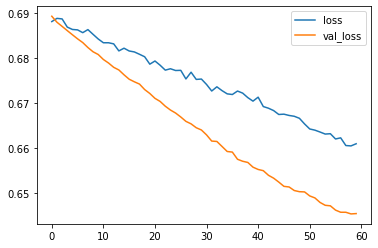

In [770]:
pd.DataFrame(model.history.history)[['loss','val_loss']].plot()

Here is a plot of accuracy vs. val_accuracy through all the epochs

<AxesSubplot:>

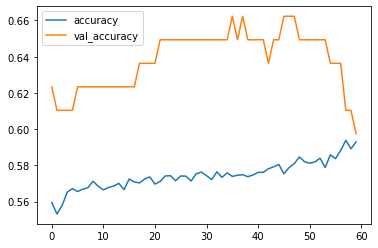

In [771]:
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot()

For both train and test, we got similar values at the last epoch for both accuracies and losses. Accuracies were around 0.59 whereas loss was around 0.65. This project allowed me to learn the importance of hyperparameter tuning, to know not to overfit or underfit to the data, and be patient as training will take some time depending on how big the dataset is. Hyperparameter tuning allows you to tune based on whether you are satisfied with the accuracy or loss. The model we created for this project isn't the best. However, with a deeper dive into NLP and/or RNN, or hyperparameter tuning, we can get a higher score on accuracy

We will now get predictions for the test dataset from the beginning

In [36]:
tokenized_text = []
for text in range(0,len(test)):
    a = word_tokenize(text_preprocess(test['text'].iloc[text]))
    tokenized_text.append(a)

In [37]:
from keras.preprocessing import text, sequence
vectorizer = text.Tokenizer()
vectorizer.fit_on_texts(tokenized_text)
vectorized_text = vectorizer.texts_to_sequences(tokenized_text)
test_X = sequence.pad_sequences(vectorized_text)

Make sure to scale between 0 and 16,824 since that was the scale used for training above

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((0,16824))
test_X = scaler.fit_transform(test_X)

In [778]:
# make sure to use np.round to round predictions to either 0s or 1s

In [779]:
pred = np.round(model.predict(test_X)).astype(int)

In [773]:
test['target'] = pred
predictions = test[['id','target']]
predictions = predictions.set_index('id')

In [774]:
predictions['target'].value_counts()

0    2554
1     709
Name: target, dtype: int64

In [775]:
predictions.to_csv('predictions62.csv')

Kaggle score of 0.57309, which is similar to the accuracies we got above!